In [1]:
# ======================================
# 1️⃣ CÀI ĐẶT & IMPORT
# ======================================
!pip install tensorflow matplotlib numpy scipy

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

# ======================================
# 2️⃣ ĐƯỜNG DẪN DATASET
# ======================================
dataset_path = 'dataset_resized'

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation'
)

num_classes = train_gen.num_classes

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [3]:

# ======================================
# 3️⃣ XÂY DỰNG MẠNG ♻️ RECYCENET
# ======================================
def build_recyclenet(input_shape=(224,224,3), num_classes=6):
    inputs = layers.Input(shape=input_shape)

    # --- Feature extractor base: MobileNetV2 ---
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs
    )
    base.trainable = False  # freeze base layers

    # --- Add skip connections + custom head ---
    x = base.output
    skip = layers.Conv2D(128, (1,1), activation='relu', padding='same')(base.layers[-20].output)
    x = layers.Concatenate()([x, skip])
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_recyclenet((224,224,3), num_classes)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\PC-09\AppData\Local\Temp\ipykernel_14280\1578407212.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,743,238 (10.46 MB)

 Trainable params: 485,254 (1.85 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:

# ======================================
# 4️⃣ HUẤN LUYỆN
# ======================================
epochs = 30
steps_per_epoch = train_gen.samples // batch_size
validation_steps = val_gen.samples // batch_size

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 533ms/step - accuracy: 0.3981 - loss: 1.6106 - val_accuracy: 0.5813 - val_loss: 1.1023
Epoch 2/30
 1/63 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.5000 - loss: 1.2238

c:\Users\PC-09\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5000 - loss: 1.2238 - val_accuracy: 0.6125 - val_loss: 1.0979
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 697ms/step - accuracy: 0.6190 - loss: 1.0143 - val_accuracy: 0.6500 - val_loss: 0.9198
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.5000 - loss: 1.3593 - val_accuracy: 0.6646 - val_loss: 0.9151
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 817ms/step - accuracy: 0.6928 - loss: 0.8423 - val_accuracy: 0.6833 - val_loss: 0.8396
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.6562 - loss: 0.6994 - val_accuracy: 0.6875 - val_loss: 0.8183
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 696ms/step - accuracy: 0.7294 - loss: 0.7448 - val_accuracy: 0.6729 - val_loss: 0.8010
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.6562 - loss: 0.9762 - val_accuracy: 0.7021 - val_loss: 0.7986
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.7590 - loss: 0.6716 - val_accuracy: 0.7063 - va

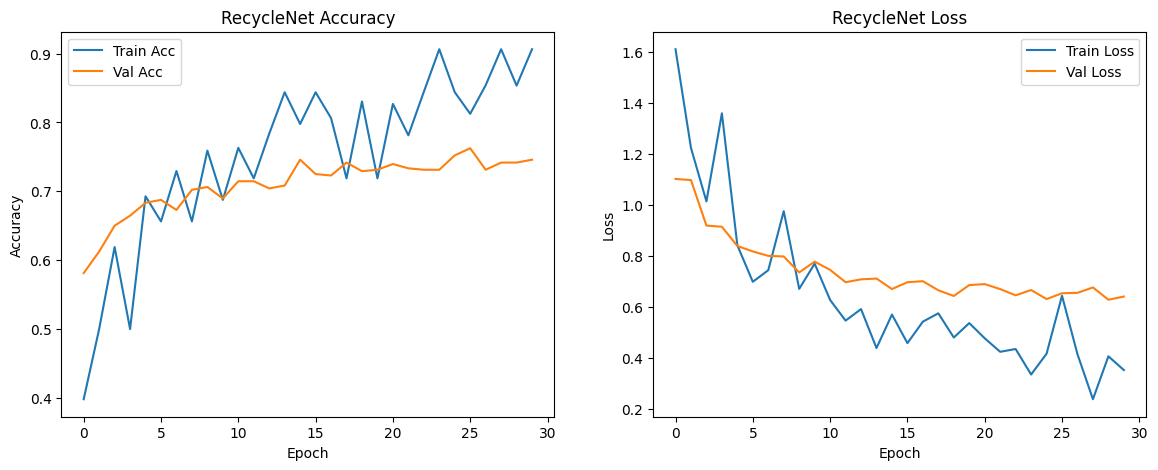

In [5]:

# ======================================
# 5️⃣ VẼ BIỂU ĐỒ KẾT QUẢ
# ======================================
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('RecycleNet Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('RecycleNet Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [6]:

# ======================================
# 6️⃣ LƯU MÔ HÌNH
# ======================================
model.save('RecycleNet_model.h5')
print("✅ Mô hình RecycleNet đã được lưu thành công!")

✅ Mô hình RecycleNet đã được lưu thành công!
